# Working with time in xarray

* **Products used:** 
[ s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background
[Time series data](https://en.wikipedia.org/wiki/Time_series) is a series of data points usually captured at successively spaced points in time. 
In a remote-sensing context, time series data is a sequence of discrete satellite images taken at the same area at successive times. 
Time series analysis uses different methods to extract meaningful statistics, patterns and other characteristics of the data. 
Time series data and analysis has widespread application ranging from monitoring agricultural crops, natural vegetation change detection, mineral prospectivity mapping, and tidal height modelling.

## Description
The `xarray` Python package provides many useful techniques for dealing with time series data that can be applied to Digital Earth Africa data. 
This notebook demonstrates how to use `xarray` techniques to:

1. Select different time periods of data (e.g. year, month, day) from an `xarray.Dataset`
2. Use datetime accessors to extract additional information from a dataset's `time` dimension
3. Summarise time series data for different time periods using `.groupby()` and `.resample()`
4. Interpolate time series data to estimate landscape conditions at a specific date that the satellite did not observe

For additional information about the techniques demonstrated below, refer to the `xarray` [time series data guide](http://xarray.pydata.org/en/stable/time-series.html). 

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np

from deafrica_tools.datahandling import load_ard, mostcommon_crs

### Connect to the datacube


In [2]:
dc = datacube.Datacube(app='Working_with_time')

## Loading Landsat data
First, we load in around two years' of Sentinel-2 data, using the [load_ard](Using_load_ard.ipynb) function and filtering for timesteps with at least 95% good-quality pixels.

In [3]:
lat, lon = 13.94, -16.54
buffer = 0.125

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2018-01', '2019-12'),
    'resolution': (-20, 20),
    'measurements':['red', 'green', 'blue', 'nir']
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)

# Load available data from Landsat 8 and filter to retain only times
# with at least 95% good data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              min_gooddata=0.95,
              output_crs=output_crs,
              align=(15, 15),
              **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 34 out of 144 time steps with at least 95.0% good quality pixels
Applying pixel quality/cloud mask
Loading 34 time steps


## Explore xarray data using time
Here we will explore several ways to utilise the time dimension within an `xarray.Dataset`. This section outlines selecting, summarising and interpolating data at specific times.

### Indexing by time
We can select data for an entire year by passing a string to `.sel()`:

In [4]:
ds.sel(time='2018')


<xarray.Dataset>
Dimensions:      (time: 12, x: 1361, y: 1392)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-08T11:46:56 ... 2018-12-14T11:...
  * y            (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x            (x) float64 3.2e+05 3.2e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 2254.0 1988.0 2706.0 ... 1732.0 1747.0
    green        (time, y, x) float32 1502.0 1348.0 1825.0 ... 1328.0 1336.0
    blue         (time, y, x) float32 815.0 742.0 1010.0 ... 1016.0 1002.0
    nir          (time, y, x) float32 3789.0 3519.0 3973.0 ... 2483.0 2496.0
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

Or select a single month:

In [5]:
ds.sel(time='2018-05')


<xarray.Dataset>
Dimensions:      (time: 1, x: 1361, y: 1392)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-23T11:39:00
  * y            (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x            (x) float64 3.2e+05 3.2e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 2626.0 2490.0 2867.0 ... 2050.0 1988.0
    green        (time, y, x) float32 1895.0 1793.0 2050.0 ... 1584.0 1542.0
    blue         (time, y, x) float32 1112.0 1080.0 1239.0 ... 1163.0 1132.0
    nir          (time, y, x) float32 3536.0 3472.0 3682.0 ... 2744.0 2686.0
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

Or select a range of dates using `slice()`. This selects all observations between the two dates, inclusive of both the start and stop values:

In [6]:
ds.sel(time=slice('2018-06', '2019-01'))


<xarray.Dataset>
Dimensions:      (time: 6, x: 1361, y: 1392)
Coordinates:
  * time         (time) datetime64[ns] 2018-10-15T11:35:46 ... 2019-01-18T11:...
  * y            (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x            (x) float64 3.2e+05 3.2e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 1099.0 1051.0 1739.0 ... 1994.0 1951.0
    green        (time, y, x) float32 1048.0 1058.0 1583.0 ... 1469.0 1409.0
    blue         (time, y, x) float32 487.0 529.0 836.0 ... 1215.0 1016.0 976.0
    nir          (time, y, x) float32 3683.0 3957.0 4215.0 ... 2814.0 2792.0
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

To select the nearest time to a desired time value, we set it to use a nearest neighbour method, `'nearest'`. We have to specify the time using a `datetime` object, otherwise xarray indexing assumes we are selecting a range, like the `ds.sel(time='2018-05')` month example above.

Here, we have picked a date at the start of December 2018. `'nearest'` will find the observation closest to that date.

In [7]:
target_time = np.datetime64('2018-12-01')

ds.sel(time=target_time, method='nearest')

<xarray.Dataset>
Dimensions:      (x: 1361, y: 1392)
Coordinates:
    time         datetime64[ns] 2018-12-09T11:47:28
  * y            (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x            (x) float64 3.2e+05 3.2e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref  int32 32628
Data variables:
    red          (y, x) float32 2376.0 2035.0 2663.0 ... 2153.0 1987.0 1938.0
    green        (y, x) float32 1610.0 1375.0 1863.0 ... 1609.0 1487.0 1416.0
    blue         (y, x) float32 777.0 654.0 970.0 867.0 ... 1179.0 1051.0 960.0
    nir          (y, x) float32 3633.0 3515.0 4003.0 ... 3072.0 2866.0 2748.0
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

You can select the closest time **before** a given time using `ffill` (forward-fill).

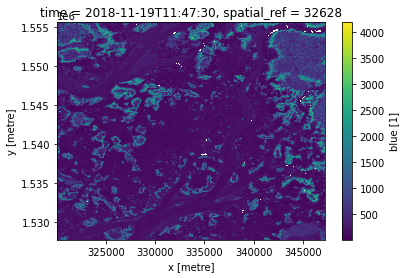

In [8]:
previous_time = ds.sel(time=target_time, method='ffill')

previous_time.blue.plot();


To select the closest time **after** a given time, use `bfill` (back-fill).

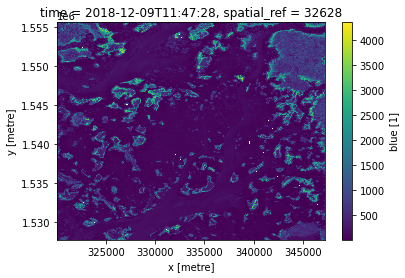

In [9]:
next_time = ds.sel(time=target_time, method='bfill')

next_time.blue.plot()

The same methods also work on a list of times:

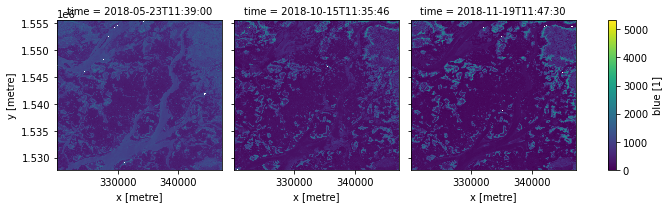

In [10]:
many_times = np.array([
    '2018-06-23',
    '2018-09-13',
    '2018-11-02'
], dtype=np.datetime64)

nearest = ds.sel(time=many_times, method='nearest')

nearest.blue.plot(col='time', vmin=0);


### Using the datetime accessor
`xarray` allows you to easily extract additional information from the `time` dimension in Digital Earth Africa data. For example, we can get a list of what season each observation belongs to:

In [11]:
ds.time.dt.season


<xarray.DataArray 'season' (time: 34)>
array(['DJF', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'MAM', 'SON',
       'SON', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'DJF', 'MAM', 'MAM',
       'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA',
       'JJA', 'SON', 'SON', 'SON', 'SON', 'SON', 'DJF'], dtype='<U3')
Coordinates:
  * time         (time) datetime64[ns] 2018-01-08T11:46:56 ... 2019-12-19T11:...
    spatial_ref  int32 32628

Or the day of the year:

In [12]:
ds.time.dt.dayofyear


<xarray.DataArray 'dayofyear' (time: 34)>
array([  8,  23,  48,  53,  63,  68,  93, 143, 288, 323, 343, 348,   3,
        18,  43,  53,  68,  73,  83,  98, 108, 123, 133, 143, 148, 158,
       183, 188, 273, 293, 303, 328, 333, 353])
Coordinates:
  * time         (time) datetime64[ns] 2018-01-08T11:46:56 ... 2019-12-19T11:...
    spatial_ref  int32 32628

### Grouping and resampling by time
`xarray` also provides some shortcuts for aggregating data over time. In the example below, we first group our data by season, then take the median of each group. This produces a new dataset with only four observations (one per season). 

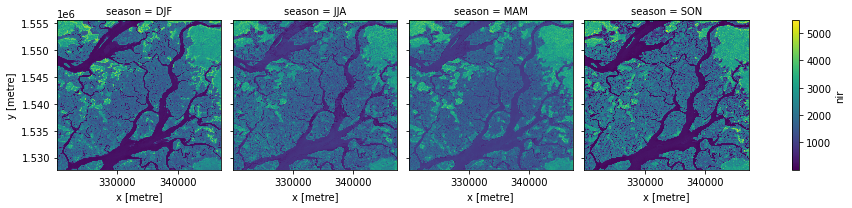

In [13]:
# Group the time series into seasons, and take median of each time period
ds_seasonal = ds.groupby('time.season').median(dim='time')

# Plot the output
ds_seasonal.nir.plot(col='season', col_wrap=4)
plt.show()


We can also use the `.resample()` method to summarise our dataset into larger chunks of time. In the example below, we produce a median composite for every 6 months of data in our dataset:

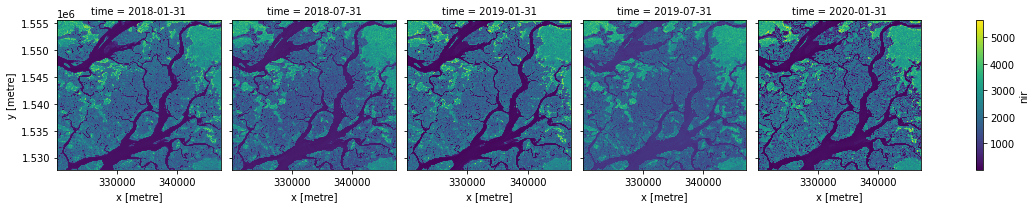

In [14]:
# Resample to combine each 6 months of data into a median composite
ds_resampled = ds.resample(time="6m").median()

# Plot the new resampled data
ds_resampled.nir.plot(col="time")
plt.show()

### Interpolating new timesteps
Sometimes, we want to return data for specific times/dates that weren't observed by a satellite. 
To estimate what the landscape appeared like on certain dates, we can use the `.interp()` method to interpolate between the nearest two observations.

By default, the `interp()` method uses linear interpolation (`method='linear'`). Another useful option is `method='nearest'`, which will return the nearest satellite observation to the specified date(s).

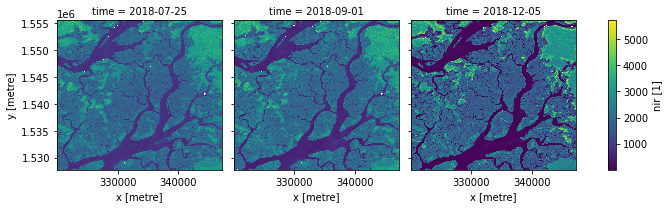

In [15]:
# New dates to interpolate data for
new_dates = ['2018-07-25', '2018-09-01', '2018-12-05']

# Interpolate Landsat values for three new dates
ds_interp = ds.interp(time=new_dates)

# Plot the new interpolated data
ds_interp.nir.plot(col='time')
plt.show()


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.4.dev63+g6ee0462c


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-20'